# TP 3 : Apprentissage non supervisé sous Python k-means et Cah

IMT Atlantique – FIL A3  <br/>
Apprentissage Automatique  <br/>

## Objectifs :

Programmer quelques méthodes de clustering, évaluer leurs performances, en utilisant la bibliothèque **Scikit-Learn** de **Python**.

## Evaluation

Vous devez rendre un code python qui tourne sur netbook Jupyter + un mini rapport (format pdf) présentant le travail réalisé, les résultats obtenus et une analyse (intéressante) de ces résultats.

### 1 Données de travail

#### 1.1 Importation, préparation des données et graphiques

On dispose de 2 jeux de données[<span id="sfn1"><sup>1</sup><span/>](#fn1) représentant un ensemble de fromages (29 observations) décrits par leurs propriétés nutritives (ex. protéines, lipides, calcium, magnésium, etc. ; 9 variables) :  <br/>
— le fichier **"fromage all.txt"** contient une description complète des 9 propriétés nutritives des 29 fromages ;  <br/>
— le fichier **"fromage.txt"** est une version simplifiée qui regroupe les 4 propriétés nutritives les plus importantes.

L’objectif est d’identifier des groupes de fromages partageant des caractéristiques similaires.  <br/>
Nous utiliserons pour cela deux approches basées sur deux librairies spécialisés pour **Python** :

1. la méthode des centres mobiles (k-means – Librairie **Scikit-Learn**) ;
2. la classification ascendante hiérarchique (Cah – **Librairie SciPy**)

Les instructions Python suivantes permettent de charger le jeu de données **fromages.txt** ainsi que d’autres librairies utiles pour la suite du TP :

In [33]:
#importation des librairies
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#chargement des données
from scipy.cluster.hierarchy import linkage
from seaborn import pairplot
from sklearn.cluster import AgglomerativeClustering, KMeans
data = pd.read_table('fromage.txt',decimal = '.')
data.head()

,sodium,calcium,lipides,proteines
0,353.5,72.6,26.3,21.0
1,238.0,209.8,25.1,22.6
2,112.0,259.4,33.3,26.6
3,336.0,211.1,28.9,20.2
4,314.0,215.9,19.5,23.4


#### 1.2 Travail à faire

Écrivez la séquence d’instructions qui permettent de :  <br/>
1. Charger le jeu de données **fromages.txt** et visualiser les infos de chaque variable séparément avec la méthode **data.info()**.  <br/>

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sodium     29 non-null     float64
 1   calcium    29 non-null     float64
 2   lipides    29 non-null     float64
 3   proteines  29 non-null     float64
dtypes: float64(4)
memory usage: 1.0 KB


2. Afficher la moyenne et l’écarts-type par attribut.  <br/>

In [35]:
data.describe()

,sodium,calcium,lipides,proteines
count,29.000000,29.000000,29.000000,29.000000
mean,210.086207,185.734483,24.158621,20.168966
std,108.678923,72.528882,8.129642,6.959788
min,22.000000,72.600000,3.400000,4.100000
25%,140.000000,132.900000,23.400000,17.800000
50%,223.000000,202.300000,26.300000,21.000000
75%,276.000000,220.500000,29.100000,23.400000
max,432.000000,334.600000,33.300000,35.700000


3. Afficher le nuage de points entre les deux derniers attributs ;  <br/>
— Regardez la description complète de la commande **scatter** sur http://matplotlib.org/api/pyplot_summary.html.  <br/>

<function matplotlib.pyplot.show(close=None, block=None)>

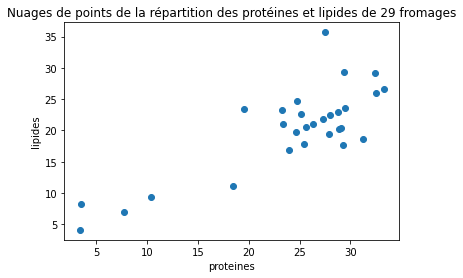

In [36]:
import matplotlib.pyplot as plt
plt.scatter(data=data,
            x='lipides',
            y='proteines')
plt.xlabel("proteines")
plt.ylabel("lipides")
plt.title('Nuages de points de la répartition des protéines et lipides de 29 fromages')

plt.show

4. Étudier les relations existantes entre les différentes attributs.  <br/>
— Utilisez la méthode **paiplot** de librairie **Seaborn** qui affiche par paire toutes les variables numériques dans une grille à plusieurs axes.  <br/>

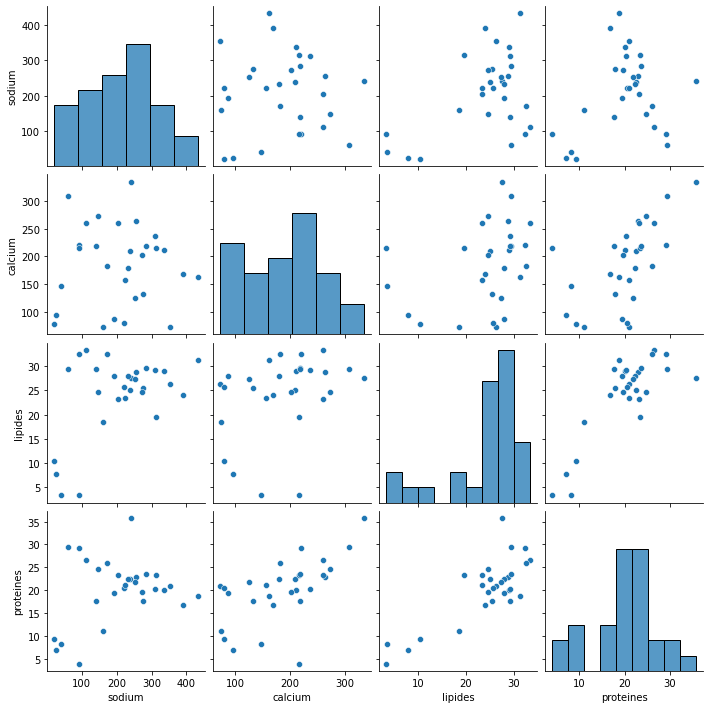

In [37]:
import seaborn as sns
sns.pairplot(data = data)



5. Que pouvez-vous en déduire sur les distribution des différents attributs ainsi que leurs corrélations ?


On remarque une corrélation entre la quantité de lipides et de protéines.

On remarque aussi une légère corrélation entre le calcium et les protéines


#### 1.3 Mise à l’échelle des données

Pour un grand nombre de modèles de machine learning, il est préférable de travailler sur des données mises à l’échelle (par exemple centrées-réduites, ou à valeurs entre 0 et 1). Pour cela, on va utiliser le module **preprocessing** de **sklearn** qui contient tout un tas de méthodes pour préparer vos données avant de les utiliser. Pour tous ces pré-traitements, le fonctionnement est le même :  <br/>
1. (a) on construit un objet de la classe visée en lui précisant certains hyper-paramètres ;  <br/>
2. (b) on appelle sa méthode **fit** pour ajuster les paramètres (par exemple moyenne et écart-type dans le cas où l’on souhaite centrer-réduire nos données) ;  <br/>
3. (c) on appelle sa méthode **transform** pour appliquer la transformation à nos données.
> ##### Note
>
> Attention, les objets sklearn attendent des données quantitatives pour être estimés. Vous devrez donc ne leur passer qu’un sous-ensemble de votre dataframe composé de ses colonnes quantitatives.

##### Travail à faire.
1. Utilisez la classe **StandardScaler** pour centrer-réduire les données de votre dataframe.

In [38]:
#centrer et réduire les données
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(data)
data_scaled = pd.DataFrame(data=std_scale.transform(data),
                           columns=data.columns)
data_scaled.head()



,sodium,calcium,lipides,proteines
0,1.342968,-1.587464,0.268066,0.121519
1,0.261393,0.337679,0.117846,0.355480
2,-0.918507,1.033649,1.144354,0.940383
3,1.179093,0.355920,0.593544,0.004538
4,0.973078,0.423272,-0.583184,0.472461


### 2 La méthode k-means

#### 2.1 Configuration de la méthode

Nous importerons le paquet **sklearn.cluster** pour utiliser la méthode **k-means** de la classe **sklearn.cluster.KMeans**. La description de l’implémentation de la méthode des K-moyennes (k-means) se trouve dans : http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html.

L’exécution de l’algorithme k-means se fait par la commande suivante :  <br/>
**KMeans(n_clusters=8, init=’k-means++’, n_init=10, max_iter=300, tol=0.0001, precompute_distances=’auto’, n_jobs=1)** :
* **n_clusters** : le nombre de classes (par défaut **n_clusters = 8**).
* **init** : {**’k-means++’**, **’random’** ou un **’ndarray’** } : est une méthode d’initialisation, par défaut **’k-means++’** :  <br/>
— **’k-means++’** : sélectionne intelligemment les centres initiaux afin d’accélérer la convergence.  <br/>
— **’random’** : choisit k observations (rangées) au hasard parmi les données pour les centres initiaux.  <br/>
— **’ndarray’** : passe en paramètre les centres initiaux sous la forme (n clusters, n features).
* **n_jobs=1** permet d’exécuter les **n_init** itérations en parallèle.

Les résultats de l’algorithme k-means sont accessibles via différents attributs : **cluster_centers** : contient les attributs en sortie : les centres, **labels_** : les numéros de cluster de chaque observation, **inertie** : la somme des distances au carré des observations vers leur centre de cluster le plus proche.

Les commandes suivantes :
* **km = KMeans(n_clusters=$k$)** permet de créer un modèle pour un ensemble de $k$ centres,
* L’instruction **km.fit(X)** utilise les données pour définir le modèle de clustering,
* **predict(X)** prédit le cluster le plus proche auquel appartient chaque échantillon.

> #### Note
> Les données représentées par le paramètre $X$ correspondent aux données centrées réduites.

#### 2.2 Travail à faire

Dans l’algorithme k-means, le nombre k de clusters est fixé au départ. A partir d’une partition initiale, on cherche à améliorer itérativement la partition en minimisant la somme des carrés des distances euclidiennes de chaque point à la moyenne des points de son cluster, notée **WCSS**. Écrivez les séquences d’instructions qui permettent de :  <br/>
1. Effectuer un clustering du jeu de données **fromage.txt** en utilisant l’algorithme K-Means avec $k = 2$ et en conservant les autres paramètres par défaut.  <br/>

In [39]:
dbf = pd.read_csv('./fromage.txt', sep='\t')
dbf.head()

,sodium,calcium,lipides,proteines
0,353.5,72.6,26.3,21.0
1,238.0,209.8,25.1,22.6
2,112.0,259.4,33.3,26.6
3,336.0,211.1,28.9,20.2
4,314.0,215.9,19.5,23.4


In [40]:
columns = ['lipides','proteines']
dbf_prot_lipi_std_scale = preprocessing.StandardScaler().fit(dbf[columns])
dbf_prot_lipi_scaled = pd.DataFrame(data=dbf_prot_lipi_std_scale.transform(dbf[columns]),
                                    columns=columns)
dbf_prot_lipi_scaled.head()

,lipides,proteines
0,0.268066,0.121519
1,0.117846,0.355480
2,1.144354,0.940383
3,0.593544,0.004538
4,-0.583184,0.472461


In [41]:
from sklearn.cluster._kmeans import KMeans
dbf_km = KMeans(n_clusters=2)
dbf_km = dbf_km.fit(X=dbf_prot_lipi_scaled)
dbf_predict = pd.DataFrame(data=dbf_km.predict(X=dbf_prot_lipi_scaled),
                           columns=['groupe'])

dbf_predict.head()


,groupe
0,1
1,1
2,1
3,1
4,1


2. Visualisez les résultats de cette classification.  <br/>

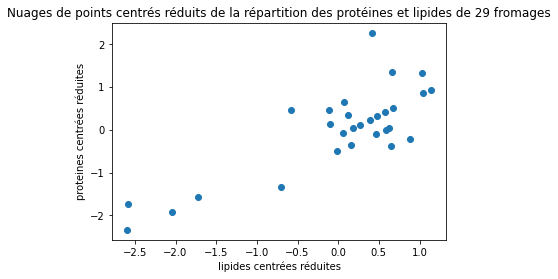

In [42]:
plt.scatter(dbf_prot_lipi_scaled['lipides'],dbf_prot_lipi_scaled['proteines'])
plt.ylabel("proteines centrées réduites")
plt.xlabel("lipides centrées réduites")
plt.title('Nuages de points centrés réduits de la répartition des protéines et lipides de 29 fromages')

plt.show()

3. Afficher le groupe de chaque fromage selon les valeurs des deux attributs **"lipides"** et **"proteines"** en fonction des labels retournés par k-means. Vous devez également afficher les centroids correspondants sur la graphique. Utilisez les commandes **scatter** et **plot**.  <br/>
On souhaite à présent déterminer la valeur optimale du paramètre k à l’aide de la méthode **Elbow**. Le principe de cette méthode est d’analyser le changement substantiel de la valeur d’inertie [<span id="sfn2"><sup>2</sup></span>](#fn2) en fonction de l’augmentation du nombre de clusters.  <br/>

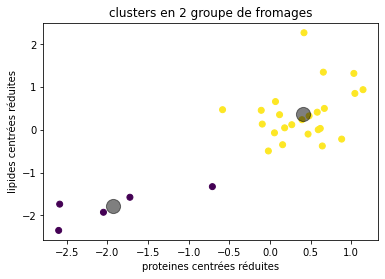

In [43]:
plt.scatter(dbf_prot_lipi_scaled['lipides'],
            dbf_prot_lipi_scaled['proteines'],
            c=dbf_predict.values)
plt.title('clusters en 2 groupe de fromages')
plt.xlabel("proteines centrées réduites")
plt.ylabel("lipides centrées réduites")

centers = dbf_km.cluster_centers_
plt.scatter(centers[:,0],
            centers[:,1],
            c='black',
            s=200,
            alpha=0.5);

plt.show()

4. Variez le nombre de groupes (**n_clusters**) entre **2 et 10**, tracez le graphique d’évolution de la valeur finale atteinte par la valeur d’inertie, pour chacune des valeurs de **n_clusters**.  <br/>

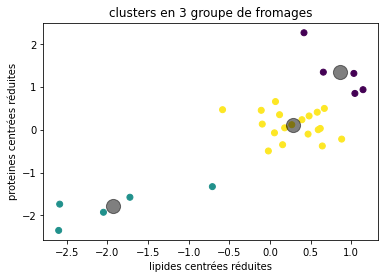

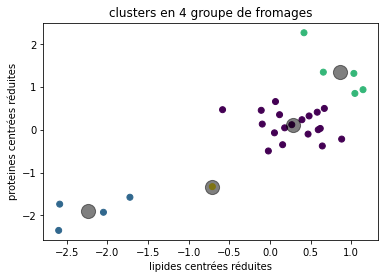

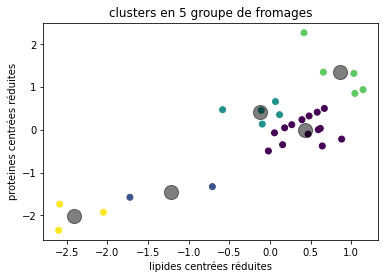

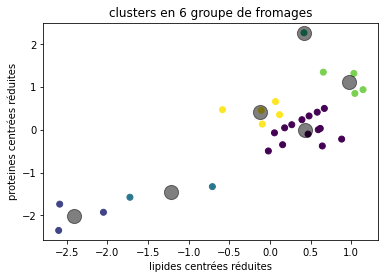

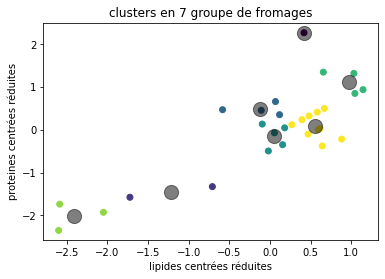

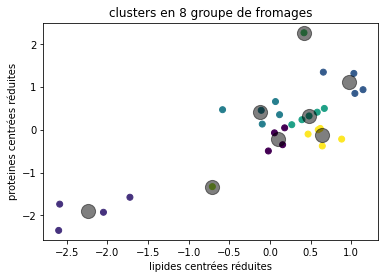

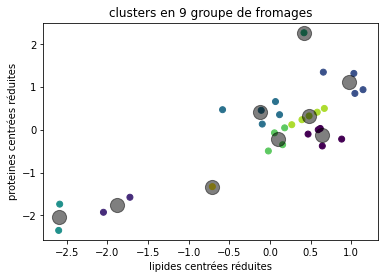

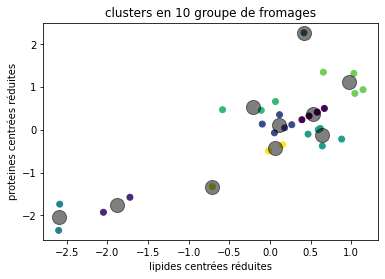

In [44]:
for i in range(3, 11):
    dbf_km = KMeans(n_clusters=i)
    dbf_km = dbf_km.fit(X=dbf_prot_lipi_scaled)
    dbf_predict = pd.DataFrame(data=dbf_km.predict(X=dbf_prot_lipi_scaled),
                               columns=['groupe'])

    plt.scatter(dbf_prot_lipi_scaled['lipides'],
                dbf_prot_lipi_scaled['proteines'],
                c=dbf_predict.values)
    plt.title(f'clusters en {i} groupe de fromages')
    plt.ylabel("proteines centrées réduites")
    plt.xlabel("lipides centrées réduites")

    centers = dbf_km.cluster_centers_
    plt.scatter(centers[:, 0],
                centers[:, 1],
                c='black',
                s=200,
                alpha=0.5);

    plt.show()

5. Quel est le meilleur nombre de clusters $k$ pour le jeu de données ?  <br/>

Visuellement le meilleur nombre de cluster semble être 3.

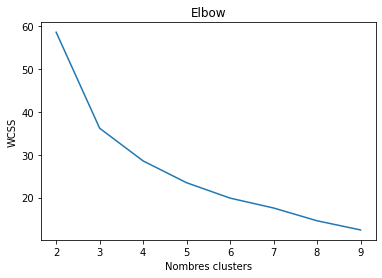

In [45]:
# calcul du nombre de cluster
wcss = []

for i in range(2, 10):
    kmeans = KMeans(n_clusters = i,
                    init = 'k-means++',
                    max_iter = 300,
                    n_init = 10,
                    random_state = 0)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# affichage de la courbe
plt.plot(range(2, 10), wcss)
plt.title('Elbow')
plt.xlabel('Nombres clusters')
plt.ylabel('WCSS')
plt.show()

La pente devient moins abrute avec 3 clusters.  <br/>
Le nombre de clusters optimal est donc bien de 3.


6. Effectuer un nouveau clustering avec la valeur optimale k trouvée précédemment et afficher à nouveau le groupe de chaque fromage selon les valeurs des deux attributs **"lipides"** et **"proteines"**. Que constatez-vous ? Expliquez.

In [46]:
dbf_km = KMeans(n_clusters=3)
dbf_km = dbf_km.fit(X=dbf_prot_lipi_scaled)
dbf_predict = dbf_km.predict(X=dbf_prot_lipi_scaled)
print(dbf_predict)

[0 0 2 0 0 0 0 0 2 2 0 0 2 1 0 1 1 0 0 2 1 0 0 0 0 0 0 0 1]


L'indice des clusters changent à chaque éxécution du code.

### 3 La Classification Ascendante Hiérarchique

#### 3.1 Configuration de la méthode

La classification ascendante hiérarchique (ou Cah) procède par fusions successives d’ensembles de points (clusters), en considérant initialement tous les points comme des clusters singletons, on fusionne à chaque étape les 2 clusters les plus proches au sens d’une distance, jusqu’à obtenir un seul cluster contenant tous les points.

La description de l’implémentation de la méthode des CAH se trouve dans :
http://scikitlearn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

L’exécution de l’algorithme Cah se fait par l’utilisation **sklearn.cluster.AgglomerativeClustering** avec la commande suivante :

In [47]:
AgglomerativeClustering(n_clusters=2, affinity='euclidean', connectivity=None,
compute_full_tree='auto', linkage='ward')

AgglomerativeClustering()

* **n_clusters** : le nombre des cluster à trouver (2 par défaut).
* **affinity** : (“euclidean” par défaut) “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, ‘precomputed’, est la métrique utilisé pour calculer la stratégie (linkage).
* **linkage** : {”ward”, ”complete”, ”average”}, (”ward” par défaut). Définit une distance entre groupes d’individus (appelé stratégie d’agrégation). Stratégie du saut minimum ou single linkage (la distance entre groupes est la plus petite distance entre éléments des deux groupes).  <br/>
Stratégie du saut maximum ou du diamètre ou complete linkage (la distance entre groupes est la plus grande distance entre éléments des deux groupes). Méthode du saut Ward (en espace euclidien, on agrège de manière à avoir un gain minimum d’inertie intra-classe à chaque itération).

#### 3.2 La classe dendogramme

Cah, à la différence de k-means, fournit un outil d’aide à la détection du nombre de classes. Une méthode connue pour trouver le nombre de clusters optimal est d’utiliser un **dendrogramme**.   <br/>
Il permet de visualiser les regroupements successifs jusqu’à obtenir un unique cluster. Il est souvent pertinent de choisir le partitionnement correspondant **au plus grand saut entre deux clusters consécutifs**.

Le nombre de clusters correspond alors au nombre de lignes verticales traversée par la coupe horizontale du dendrogramme. La description de l’implémentation de la classe se trouve dans : https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

La génération d’un dendogramme se fait en deux étapes, par l’utilisation de **scipy.cluster.hierarchy** :  <br/>
1. génération de la matrice des liens avec la méthode

In [48]:
from scipy.cluster.hierarchy import linkage
Z = linkage(data,method='ward',metric='euclidean')

   * **data** : jeu de données initial ;
   * **method** :{”ward”, ”complete”, ”average”}, (”ward” par défaut). Identique au paramètre **linkage**.
   * **metric** : (“euclidean” par défaut), est la métrique utilisée pour calculer la distance.

2. affichage du dendogramme avec la méthode **dendrogram(Z)** ; pour les autres paramètres, les valeurs par défaut sont suffisantes.

La méthode **scipy.cluster.hierarchy.fcluster(Z, t, criterion=’inconsistent’, depth=2,R=None, monocrit=None)** permet de matérialiser les différents groupes du dendogramme sous la forme d’un clustering à plat (i.e. chaque individu est associé à une classe) :  <br/>
* **Z** : le dendogramme associé aux données initiales ;
* **t** (valeur scalaire) : il s’agit du seuil (la heuteur) à utiliser pour former le clustering à plat.
* **criterion** : {”inconsistent”, ”distance”, ”maxclust”, ”monocrit”, ”maxclust monocrit”}, ils correspondent aux critères utilisés pour former le clustering à plat. Le critère ”distanc” permet de former des clusters de sorte que les observations originales dans chaque groupe sont distantes d’au plus t.

#### 3.3 Travail à faire

1. Afficher le dendogramme associé au jeu de données **fromage_all.txt**. Pensez à mettre à l’échelle les données du jeu.

In [49]:
from scipy.cluster.hierarchy import linkage
data_all = pd.read_table('fromage_all.txt',decimal = '.')
data_all.head()

,Fromages,calories,sodium,calcium,lipides,retinol,folates,proteines,cholesterol,magnesium
0,CarredelEst,314,353.5,72.6,26.3,51.6,30.3,21.0,70,20
1,Babybel,314,238.0,209.8,25.1,63.7,6.4,22.6,70,27
2,Beaufort,401,112.0,259.4,33.3,54.9,1.2,26.6,120,41
3,Bleu,342,336.0,211.1,28.9,37.1,27.5,20.2,90,27
4,Camembert,264,314.0,215.9,19.5,103.0,36.4,23.4,60,20


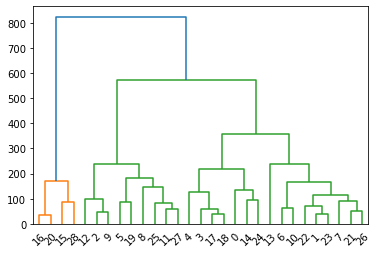

In [50]:
from scipy.cluster.hierarchy import dendrogram
Z = linkage(data_all.drop(columns='Fromages'),
            method='ward',
            metric='euclidean')
plt.figure()
dn = dendrogram(Z)

2. Faites le lien entre le dendrogramme et les valeurs de seuil permettant de trouver des clusters raisonnables pour le jeu de données **fromage_all.txt**.

In [51]:
data_all = pd.read_table('fromage_all.txt',decimal = '.')
data_all.head()

,Fromages,calories,sodium,calcium,lipides,retinol,folates,proteines,cholesterol,magnesium
0,CarredelEst,314,353.5,72.6,26.3,51.6,30.3,21.0,70,20
1,Babybel,314,238.0,209.8,25.1,63.7,6.4,22.6,70,27
2,Beaufort,401,112.0,259.4,33.3,54.9,1.2,26.6,120,41
3,Bleu,342,336.0,211.1,28.9,37.1,27.5,20.2,90,27
4,Camembert,264,314.0,215.9,19.5,103.0,36.4,23.4,60,20


In [52]:
data_all2=data_all.drop(columns=['Fromages'])
data_all2.head()

,calories,sodium,calcium,lipides,retinol,folates,proteines,cholesterol,magnesium
0,314,353.5,72.6,26.3,51.6,30.3,21.0,70,20
1,314,238.0,209.8,25.1,63.7,6.4,22.6,70,27
2,401,112.0,259.4,33.3,54.9,1.2,26.6,120,41
3,342,336.0,211.1,28.9,37.1,27.5,20.2,90,27
4,264,314.0,215.9,19.5,103.0,36.4,23.4,60,20


In [53]:
std_scale_all = preprocessing.StandardScaler().fit(data_all2)
data_all_scaled = std_scale_all.transform(data_all2)
data_all_scaled[:5]

array([[ 0.15462997,  1.34296773, -1.5874644 ,  0.26806626, -0.67228985,
         1.50091119,  0.12151868, -0.165242  , -0.62630917],
       [ 0.15462997,  0.26139273,  0.33767911,  0.11784555, -0.16266248,
        -0.57384259,  0.35547995, -0.165242  ,  0.00310054],
       [ 1.11791739, -0.91850727,  1.03364936,  1.1443537 , -0.53330057,
        -1.02525346,  0.94038312,  1.63626853,  1.26191996],
       [ 0.4646535 ,  1.17909273,  0.35592027,  0.59354445, -1.28300033,
         1.2578438 ,  0.00453804,  0.55536221,  0.00310054],
       [-0.39898349,  0.97307845,  0.42327223, -0.5831844 ,  1.49257351,
         2.03045086,  0.47246058, -0.52554411, -0.62630917]])

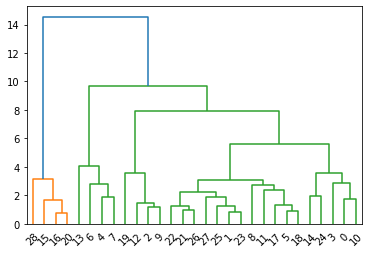

In [54]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(data_all_scaled,method='ward',metric='euclidean')
dZ = hierarchy.dendrogram(Z)

On peut remarquer que le saut le plus grand est atteint avec un nombre de cluster de 2.  <br/>
On retrouve également des sauts marqués pour un nombre de cluster de 3, 4 et 5 ce qui correspond aux différents changements de la courbe Elbow.

3. Effectuer un clustering du jeu de données en utilisant l’algorithme Cah avec le critère d’inertie de **Ward**, puis afficher les groupes des différents fromages. Que pouvez-vous en déduire sur cette classification ?

In [55]:
ward=AgglomerativeClustering(n_clusters=2, affinity='euclidean', connectivity=None,
compute_full_tree='auto', linkage='ward').fit(data_all_scaled)
ward.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1])

On retrouve bien un groupe de 4 fromages correspondant au groupe vert sur le dendrogramme.  <br/>
Les autres fromages sont regroupés dans un second groupe en rouge sur le dendrogramme.

4. Modifier l’attribut linkage : ”complete”, ”average”. Affichez les dendogrammes associés. Quel est le meilleur nombre de clusters ? Que pouvez-vous en déduire sur la nouvelle classification ?

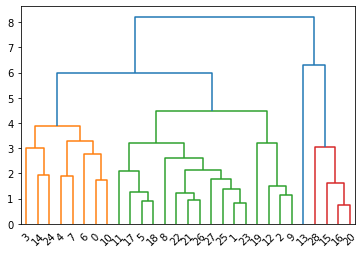

In [56]:
Z2 = hierarchy.linkage(data_all_scaled,method='complete',metric='euclidean')
dZ2 = hierarchy.dendrogram(Z2)

In [57]:
complete=AgglomerativeClustering(n_clusters=4, affinity='euclidean', connectivity=None,
compute_full_tree='auto', linkage='complete').fit(data_all_scaled)
complete.labels_

array([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 3, 3, 0, 0, 0, 3, 0,
       0, 0, 1, 0, 0, 0, 3])

Avec la méthode complete, le saut le plus grand est atteint pour un nombre de cluster de 4.  <br/>
Avec un groupe de 5 fromages, un groupe de 1 fromage, un groupe de 8 fromages et un groupe de 15 fromages.

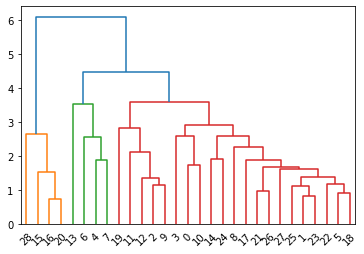

In [58]:
Z3 = hierarchy.linkage(data_all_scaled,method='average',metric='euclidean')
dZ3 = hierarchy.dendrogram(Z3)

In [59]:
average=AgglomerativeClustering(n_clusters=3, affinity='euclidean', connectivity=None,
compute_full_tree='auto', linkage='average').fit(data_all_scaled)
average.labels_

array([0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1])

Avec cette méthode le nombre de cluster optimal est de 3.  <br/>
On retrouve le premier groupe vert identique à celui de la méthode ward, puis un second groupe de 4 autres fromages et un troisième groupe avec les autres fromages.

### 4 Références
1. K-Means Clustering in Python : A Practical Guide.
https://realpython.com/k-means-clustering-python/.
2. K-Means Clustering of Iris Dataset.
https://www.kaggle.com/khotijahs1/k-means-clustering-of-iris-dataset
3. K-Means Clustering in Python with scikit-learn.
https://www.datacamp.com/community/tutorials/k-means-clustering-python
4. scikit-learn : machine learning in Python.
http://scipy-lectures.org/packages/scikit-learn/
5. A Beginner’s Guide to Hierarchical Clustering and how to Perform it in Python.
https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering
6. SciPy Hierarchical Clustering and Dendrogram Tutorial. https://joernhees.de/blog/
2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

[<sup>1</sup>](#sfn1)<span id="fn1"> Les données proviennent de la page de cours de Marie Chavent : http://www.math.u-bordeaux.fr/~mchave100p/teaching/</span>

[<sup>2</sup>](#sfn2)<span id="fn2"> indicateur de qualité de la solution qui mesure l’aptitude des individus à être plus proches de ses congénères du même groupe que des individus des autres groupe : paramètre WCSS.</span>